<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---


# **CNNs: convolutional neural networks**


#### **Morning contents/agenda**

1. What are convolutions?

2. How do we use them? (`Torch` layer operations)

3. Visual roadmap of a CNN

4. Implementation of a network similar to LeNet5

5. Training our LeNet5-like network on `FasionMNIST`


#### **Learning outcomes**

1. Have a clear idea of how convolutions work

2. Understand the parameters trained in a CNN

3. CNN architectures and combinations with other types of layers

4. Implementation of  asimple CNN in `PyTorch`

<br>

#### **Afternoon contents/agenda**

1. Dropout and batch normalisation

2. Training with data augmentation

#### **Learning outcomes**

1. Implement dropout and batchnorm layers in `PyTorch`

2. Perform data augmentations and understand its effects


<br/>

---

<br/>

In [1]:
!pip install pycm livelossplot
!pip install torchsummary 
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 954 kB/s 
     |████████████████████████████████| 595 kB 12.0 MB/s 
     |████████████████████████████████| 1.6 MB 16.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## 1. Dropout and batch normalisation

Modify your LeNet-5 network to include dropout and batch normalisation

Only run the final training (with all the training data, no splits) with all the data and compare the accuracy and loss values with the network we trained this morning without dropout or batch normalisation.

In [3]:
class LeNet5drbn(nn.Module):
  def __init__(self):
    super(LeNet5drbn, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.s2_bn = nn.BatchNorm2d(6)
    # self.s2_dr = nn.Dropout2d(p=0.2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    # self.c3_bn = nn.BatchNorm2d(16)
    self.c3_dr = nn.Dropout2d(p=0.5)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function
    
  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2_bn(self.s2(x)))                                      # activate pass through the second layer
    # x = self.s2_dr(x)                                      # activate pass through the second layer
    # x = self.act(self.c3_bn(self.c3(x)))                                      # activate pass through the third layer
    x = self.act(self.c3(x))
    x = self.c3_dr(x)
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                     # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output
  
x = torch.randn((1, 1, 28, 28)).to(device)
model = LeNet5drbn().to(device)
y = model(x)
print(y)
# print(model)
summary(model, (1, 28, 28))

tensor([[-0.0564,  0.0564,  0.0387, -0.0352, -0.1217,  0.0228,  0.1460,  0.1426,
         -0.0038,  0.0653]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
       BatchNorm2d-4            [-1, 6, 14, 14]              12
              ReLU-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              ReLU-7           [-1, 16, 10, 10]               0
         Dropout2d-8           [-1, 16, 10, 10]               0
         MaxPool2d-9             [-1, 16, 5, 5]               0
             ReLU-10             [-1, 16, 5, 5]               0
           Linear-11                  [-1, 120]          48,120
             ReLU-12           

In [4]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split

In [5]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Standardise and split the MNIST dataset:

The original MNIST data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255).

In [6]:
def apply_standardization(X): # define an standardisation function
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

In [7]:
# standardise the data
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data:

Remember that we use TensorDataset to be able to operate on the dataset without having to load it all in memory.

And remember that torch likes all categorical data to be in a ```.long()``` format.

In [8]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

### Provided Train, Validation and Evaluate Functions

There is an error in these functions. Can you spot it?

In [9]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Set the hyperparameters of your model

- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [10]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### Perform the training of the network and validation

- Instantiate our model, optimizer and loss function
- Set the random number generator seed using ```set_seed``` to make everything reproducible.
- Use a sensible loss (criterion) for the multi-class classification problem.

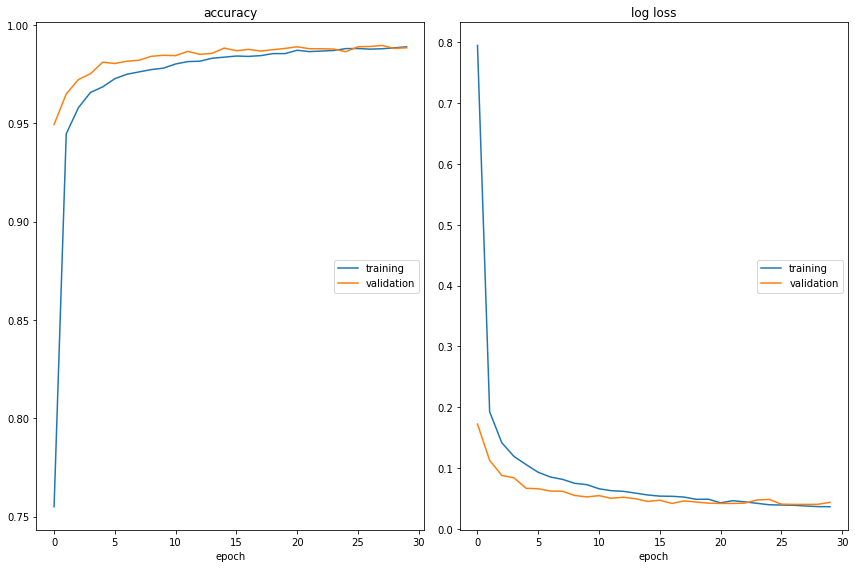

accuracy
	training         	 (min:    0.755, max:    0.989, cur:    0.989)
	validation       	 (min:    0.949, max:    0.990, cur:    0.988)
log loss
	training         	 (min:    0.036, max:    0.795, cur:    0.036)
	validation       	 (min:    0.040, max:    0.172, cur:    0.044)


In [11]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5drbn().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)
  
  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model(0.5)

### Use the evaluation function defined above to make predictions.

This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [12]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

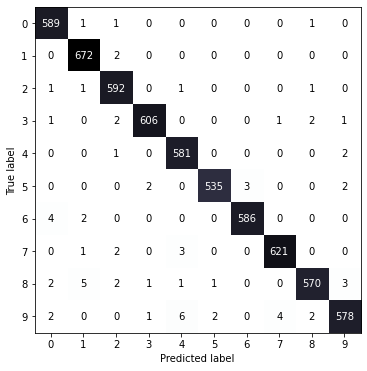

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

<br>

---

<br>

## 2. Training with data augmentation


Reminder of Custom Datasets and Transforms (from Debbie's lectures):

Pytorch allows us to simply extend the available Datasets to more custom functionality. Here we provide an example of such a custom dataset class. You can see that there are 3 functions we need to implement:

- init(args, *kwargs): this will handle everything prior to actually using the dataset
- len(self): returns the length of the dataset i.e. the number of data items
- getitem(self, idx): this method takes an index of a specific data item and returns that item:
  - you can do whatever you want in these functions: apply transforms, normalize data, perform another computation, etc.
  - here we also have the functionality to apply a set of [torchvision.transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.



Define a custom image TensorDataset:

In [14]:
from torch.utils.data import Dataset 

class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        sample = sample.view(1, 28, 28).float()/255.
        if self.transform:
            sample = self.transform(sample)

        return sample, label

### Transforms

Transforms can be used to perform manipulation of individual data prior to passing the data to our models.
This is useful for:
 - Data-augmentation i.e. creating slightly modified instance of the data we have while preserving their labels.
 - Data Preprocessing: Such as Normalization, Histogram Equalization 
 - Transforming Targets: You may have complex labels that should change together with changes in the preprocessing of the images
 
 Pytorch and especially torchvision provides a [number of transforms](https://pytorch.org/docs/stable/torchvision/index.html) for you to use!
 A nice tutorial on custom dataloaders and transforms can be found [here](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).
 
 The (probably) most state-of-the-art library for image augmentation is [albumentations](https://github.com/albu/albumentations) which has been successfully applied in winning kaggle competitions.
 

In [15]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage


#Often we will want to apply more transformations at training time than test time, therefore here we have two different ones
train_transform = Compose([
    ToPILImage(),
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 
]) ##Compose different transforms together. PIL is Python Imaging Library useful for opening, manipulating, and saving many different image file formats.

#In Validation and Test Mode we only want to normalize our images, because they are already tensors
validation_test_transform = Compose([
    Normalize(mean=[0.1307], std=[0.3081])
])

### `code along` Training with data augmentation

- Instantiate a ```CustomImageTensorDataset``` with data from the MNIST dataset
- Provide the training and validation and testing datasets with the right transforms
- Train LeNet-5 with data-augmentation on a validation set, then train on the full training set and report accuracies. Did you improve the model?






#### Create the ```CustomImageTensorDataset```:

In [16]:
mnist_train = MNIST("./", download=True, train=True)   # download mnist
X_train, y_train = mnist_train.data[indices[0]], mnist_train.targets[indices[0]]    # split in train and validation
X_val, y_val = mnist_train.data[indices[1]], mnist_train.targets[indices[1]]

custom_mnist_train = CustomImageTensorDataset(X_train, y_train, transform=train_transform)     # create train custom dataset
mnist_validation = CustomImageTensorDataset(X_val, y_val, transform=validation_test_transform) # create validation custom dataset
mnist_test = CustomImageTensorDataset(X_test, y_test, transform=validation_test_transform)     # create test custom dataset

print(custom_mnist_train.__len__())
print(mnist_validation.__len__())
print(mnist_test.__len__())

54000
6000
10000


### Training LeNet5 with data augmentation

In [17]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function
    
  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[ 0.0780, -0.0821,  0.1691,  0.0545, -0.0719,  0.1797, -0.0090,  0.0132,
          0.1232, -0.1104]], grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


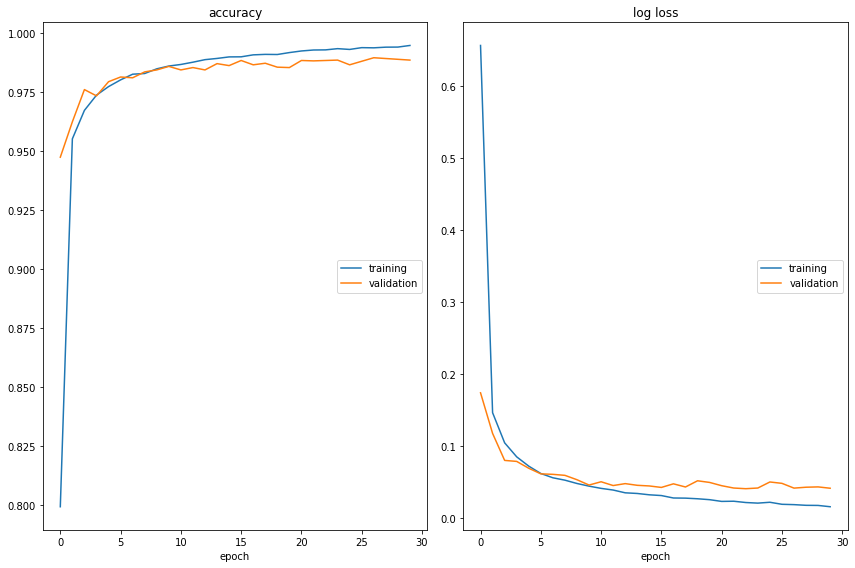

accuracy
	training         	 (min:    0.799, max:    0.995, cur:    0.995)
	validation       	 (min:    0.947, max:    0.990, cur:    0.989)
log loss
	training         	 (min:    0.016, max:    0.656, cur:    0.016)
	validation       	 (min:    0.041, max:    0.174, cur:    0.042)


In [18]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()
      
  return model

model = train_model_augmented(custom_mnist_train, mnist_validation)

In [19]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

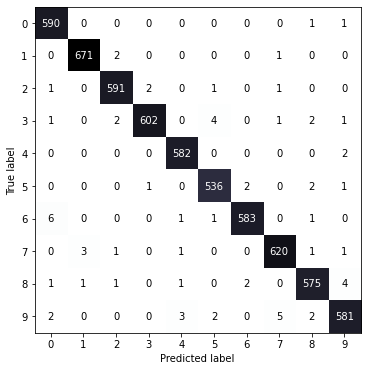

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

### Alternative implementation of the transforms

We can also define transforms directly when we get MNIST from [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/datasets.html#mnist)



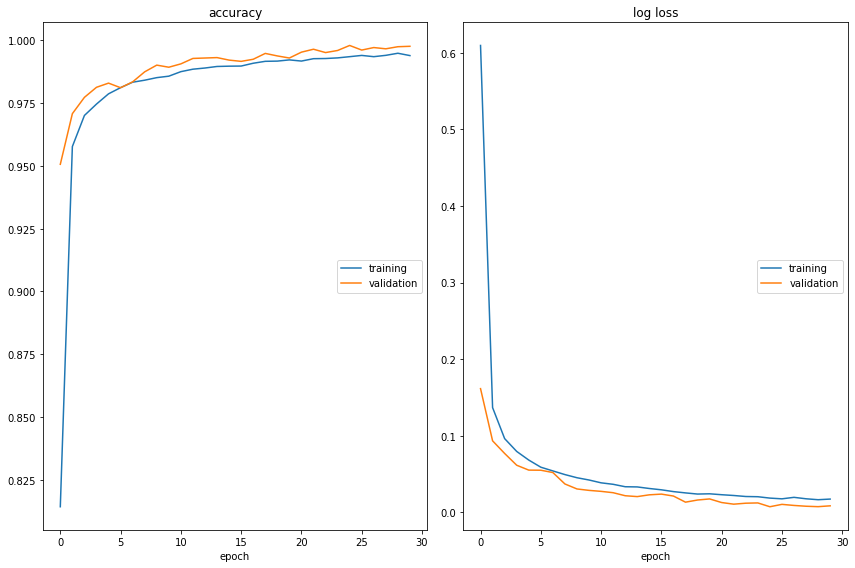

accuracy
	training         	 (min:    0.814, max:    0.995, cur:    0.994)
	validation       	 (min:    0.951, max:    0.998, cur:    0.998)
log loss
	training         	 (min:    0.017, max:    0.610, cur:    0.017)
	validation       	 (min:    0.007, max:    0.162, cur:    0.009)


In [21]:
pretransform_mnist_train = MNIST("./", download=True, train=True, transform=Compose([
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]), 

]))

model = train_model_augmented(pretransform_mnist_train, mnist_validation)

In [22]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

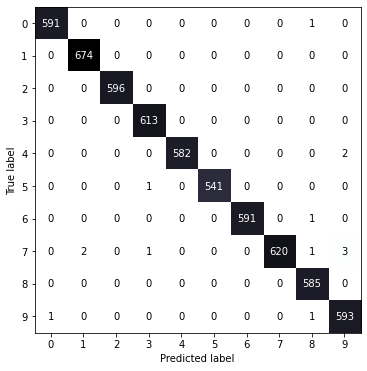

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

reference result from this morning plain Lenet-5 implementation for reference:

<img src="https://drive.google.com/uc?id=1Q9dWZOCYKE_-looC8455K5hxEokZ7i5B" width="600"/>